Strong perturbation
===================

In this numerical experiment, one considers the propagation of a **strong** perturbation in a collisionless plasma model.
The perturbation is initiated by sinusoidal velocity with an amplitude on the order of the ion acoustic velocity.
The wavelength of this sinusoid is equal to the size of the simulation domain and moving in the $x$ direction.

The perturbation being strong, things will not occure in a linear way and we aim at understanding how this velocity fluctuation is developping.

In [1]:
import os
import sys

The paths below have eventually to be modified, depending on where you install the src of this practical training as well as the PHARE code.

In [20]:
home = os.environ['HOME']
work_path = os.path.join(home, 'far/farTeach/2026/strong')
src_path = os.path.join(home, 'far/PHARE')
build_path = os.path.join(home, 'far/builds/release/ufunc')

In [3]:
sys.path.append(os.path.join(src_path, "pyphare"))

In [4]:
import subprocess
import pyphare
import matplotlib.pyplot as plt
from pyphare.pharesee.run import Run
from pyphare.core.operators import dot, cross, sqrt, modulus, grad
from pyphare.core.ufuncs import gF, peakIds
import numpy as np
from numpy import polyfit

# Fluid case

You will focus on two simulations that only diﬀer by the fluid temperature, that is $T=0.01$ for run **A** and $T=1.0$ for run **B**.

*We will use capital letter for the names of the fluid runs and non-capital for hybrid runs*.

Being in the MHD case, these temperature are then the one of a single fluid (composed of protons and electrons).

The initial velocity profile $u$ is sinusoidal with an amplitude equal 1.5.
This velocity ﬂuctuation is hence comparable to the ion acoustic speed.

For this set of simulation, you will study how the velocity profile is modifying with time, and how it is related to the density profile.
Consider that for an isothermal or polytropic MHD fluid, the density profile straightforwardly gives the pressure profile.

## Sample questions

1. What determines the time $t^{\star}$ (linear time scale or steepening time scale) corresponding to the formation of the steep gradients in both cold and hot cases ?
2. Can you explain the numerical catastroph that happens in the cold case **A** ?

# Hybrid case

In the hybrid case, both electron and proton temperature can be different, and can also evolve in a diffrernt way.
You will then focus on three different cases :
1. run **a** for which $T_e = T_p = 0.005$
2. run **b** for which $T_e = 0.12$, $T_p = 0.005$
3. run **c** for which $T_e = 0.25$, $T_p = 0.02$

## Run the `PHARE` code in dedicated conditions

In the cold case, you will focus on the proton dynamics in the phase space ($x; u$) for the case **a**.
The simulation can be seen as the collisionless version of the case .
Protons are essentially free streaming with no force acting on them.

 ## Cold electron case : run a

In [5]:
Ti = 0.005
Te = 0.005
run_name = "spa"

In [6]:
run_path = os.path.join(work_path, run_name)

In [7]:
if os.path.isdir(run_path):
    files = os.listdir(run_path)
else:
    files = []

In [8]:
if 'PYTHONPATH' in os.environ:
    os.environ['PYTHONPATH'] += os.pathsep + os.path.join(src_path, "pyphare")
else:
    os.environ['PYTHONPATH'] = os.pathsep + os.path.join(src_path, "pyphare")
os.environ['PYTHONPATH'] += os.pathsep + build_path

In [9]:
if 'ions_charge_density.h5' not in files :
    os.chdir(work_path)
    subprocess.run(['mpirun', '-n', '2', '/usr/bin/python3', work_path+'/sp.py', run_name, str(Te), str(Ti)], env=os.environ)

In [10]:
run  = Run(run_path)

In [11]:
times = np.arange(0, 21, 4)

In [12]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

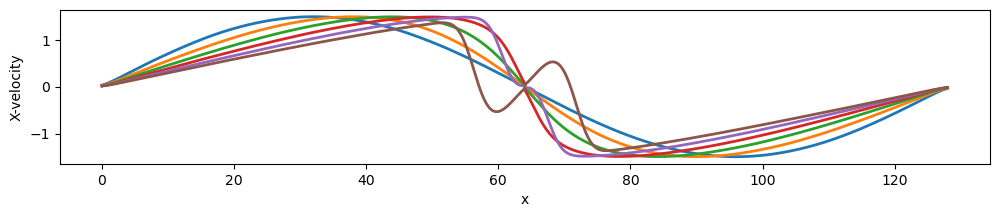

In [13]:
fig, ax = plt.subplots(figsize=(12,2))

for i, time in enumerate(times):
    V = run.GetVi(time)
    v = gF(V, sigma=6)

    v.plot(qty='x', ax=ax, ls='solid', lw=2.0, color=colors[i%10], ylabel='X-velocity')

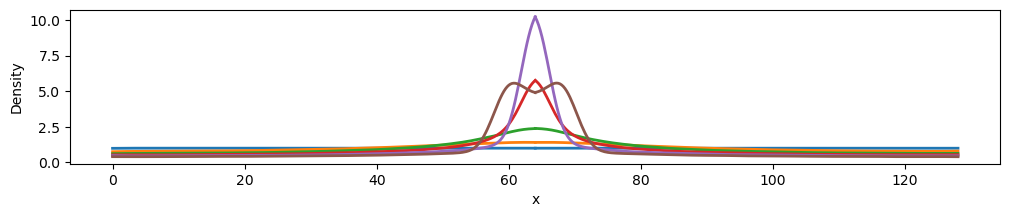

In [14]:
fig, ax = plt.subplots(figsize=(12,2))

for i, time in enumerate(times):
    N = run.GetNi(time)
    n = gF(N, sigma=6)

    n.plot(qty='value', ax=ax, ls='solid', lw=2.0, color=colors[i%10], ylabel='Density')

(0.0, 15.0)

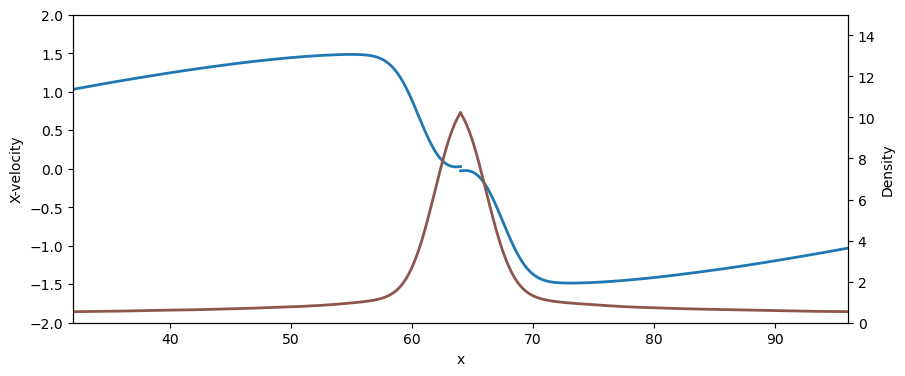

In [15]:
time = 16.0

fig, ax1 = plt.subplots(figsize=(10,4))

V = run.GetVi(time)
v = gF(V, sigma=6)

v.plot(qty='x', ax=ax1, ls='solid', lw=2.0, color=colors[0], ylabel='X-velocity')

N = run.GetNi(time)
n = gF(N, sigma=6)

ax2 = ax1.twinx()

n.plot(qty='value', ax=ax2, ls='solid', lw=2.0, color=colors[i%10], ylabel='Density')

ax1.set_xlim([32, 96])
ax1.set_ylim([-2, +2])
ax2.set_ylim([0, 15])

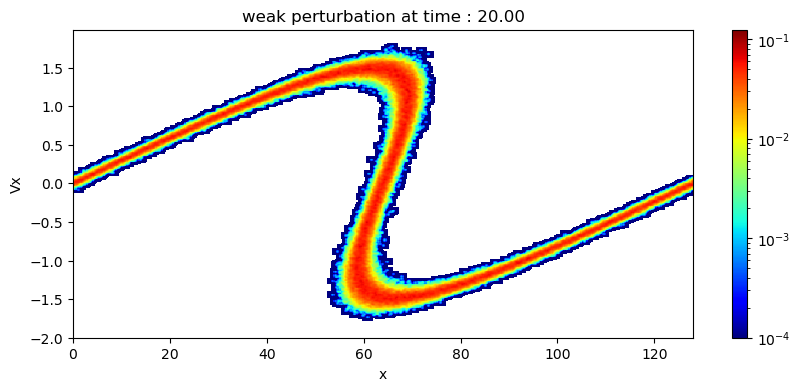

In [16]:
time=20
r = Run(run_path)
ions = r.GetParticles(time, ["protons",])

fig, ax = plt.subplots(figsize=(10,4))

p,f = ions.dist_plot(axis=("x", "Vx"),
                     ax=ax,
                     norm = 0.4,
                     finest=True,
                     gaussian_filter_sigma=1,
                     vmin=-2,vmax=2,
                     dv=0.01,
                     title="weak perturbation at time : {:.2f}".format(time),
                    )

Protons are essentially free streaming with no force acting on them.
During the late phase of the evolution, in some regions of space, three distinct populations of protons with distinct average velocity coexist without any notable interaction.
This can be observed with a slice of the ($x; u$) phase space at a given $x$ value, more precisely close to the folding of the phase-space ribbon.

Fluid quantities such as the particle density $n$, the fluid velocity $u$, the pressure $p$ and the heat flux $q$ are defined as the moments of the distribution function $f(x,v,t)$ for the one-dimensional case.
These moments are defined as
\begin{eqnarray}
n(x, t) & = & \int f(x,v,t) \mathrm{d} v \\
n(x, t) u(x,t) & = & \int v f(x,v,t) \mathrm{d} v \\
p(x, t) & = & \int (v-u)^2 f(x,v,t) \mathrm{d} v \\
q(x, t) & = & \int (v-u)^3 f(x,v,t) \mathrm{d} v \\
\end{eqnarray}

The temperature is deﬁned as $T = p/n$

## Sample questions

You may address various questions by noting that the distribution function can be approximated at any position $x$ by $f = \sum_i v_i \delta(v_i)$ where $n_i$ and $v_i$ are the density and the velocity of the various branches of the distribution function.

1. How do you explain the high pressure building up in the center
2. Can you give an estimate of the maximum temperature at the center as a func-
tion of the parameters of the initial condition ?
3. Can you calculate and plot the fluid velocity $u$ ?
4. What can you say about the heat ﬂux $q$ ?
5. In order to approximate a collisionless system using a ﬂuid model one has to choose a closure relation9. A simple possible closure (which at least works dimensionally) could be $q = Apu$ where $A$ is a numerical constant, $p$ the pressure and $u$ the ﬂuid velocity. Could such a closure apply to the above case ?
6. any suggestions of question ?

## Hot electron case : run b & c

The pressure of the electrons is no longer negligible for run **b** and **c**.
As a consequence, the gradients of the electron pressure which appear in the system induce a suﬃciently strong electric field to aﬀect the protons' trajectories as you can see in the phase space.
In particular, with respect to the case **a**, in **b** some of the protons are accelerated to form beams of high velocity (with respect to the simulation frame).
To see this, you can plot the spatial profile of the electric field.

## Sample questions

1. Where do the high energy protons come from ? By what are they accelerated ?
2. Discuss diﬀerences between the colde case (run **a**) and warm cases (run **b** and **c**) ?
3. What are the differences between runs **b** and **c** ?
4. Any suggestions of questions ?

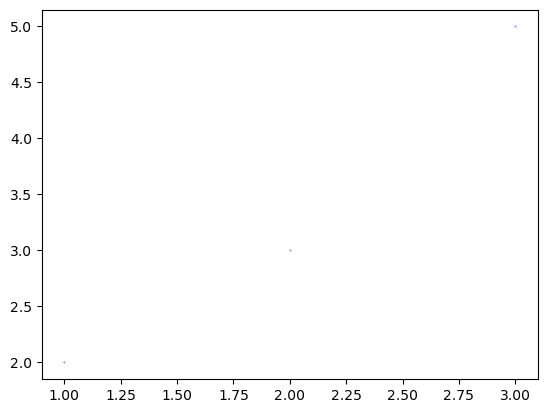

In [17]:
plt.plot([1, 2, 3], [2, 3, 5], color='b', linestyle=None, marker='.', linewidth=0, markersize=0.5, alpha=1)

In [18]:
a=np.arange(0,30,0.2)

In [19]:
a[::2] # subsampling every 2 points

array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
        4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
        8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
       13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
       17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. , 20.4, 20.8, 21.2, 21.6,
       22. , 22.4, 22.8, 23.2, 23.6, 24. , 24.4, 24.8, 25.2, 25.6, 26. ,
       26.4, 26.8, 27.2, 27.6, 28. , 28.4, 28.8, 29.2, 29.6])

draw a slice of the phase space... dist_plot(..., slice=(None, 12), ...)